# Tutorial Two: Creating an experimental object 

## Introduction 

The working engines of IPTK are the classes Experiment, introduced in this tutorial, and ExperimentalSet, introduced in the next tutorial. The Experimental object act as an anchor point connecting, the identified peptides with the expression value of their parent transcript, with the expression values with the proband metadata and with the HLA allele(s) from which peptides were eluted. We start the tutorial by preparing the input to the class constructor, then we create an experimental object and finally we use the class API along with analysis and visualization module to demonstrate different analysis methods enabled by the library. 

## Background

To give some biological insights into the current tutorial, let's start first by describing how the dataset used in this tutorial has been generated. The dataset was obtained from the [HLA-Ligand Atlas](https://hla-ligand-atlas.org/hlas). The data represents the 
small intestine immunopeptidome of patient, AUT01-DN03.   

## Loading the module

In [1]:
from IPTK.Classes.Experiment import Experiment
from IPTK.Classes.Database import SeqDB, GeneExpressionDB, CellularLocationDB,OrganismDB
from IPTK.Classes.Tissue import Tissue
from IPTK.Classes.HLASet import HLASet
from IPTK.Classes.Proband import Proband
from IPTK.Classes.Peptide import Peptide 
from IPTK.IO.InFunctions import parse_text_table
from IPTK.IO.OutFunctions import write_auto_named_peptide_to_fasta   
from IPTK.Visualization.vizTools import plot_peptide_length_dist
from IPTK.Visualization.vizTools import plot_num_peptides_per_organism
from IPTK.Visualization.vizTools import plot_num_peptides_per_parent
from IPTK.Visualization.vizTools import plot_parent_protein_expression_in_tissue
from IPTK.Visualization.vizTools import plot_gene_expression_vs_num_peptides
from IPTK.Visualization.vizTools import plot_num_protein_per_location
from IPTK.Visualization.vizTools import plot_num_peptide_per_go_term
from IPTK.Analysis.AnalysisFunction import get_sequence_motif
from IPTK.IO.OutFunctions import write_auto_named_peptide_to_fasta
from IPTK.Visualization.vizTools import plot_motif
from IPTK.Analysis.AnalysisFunction import compute_binary_distance 
from IPTK.Visualization.vizTools import plot_protein_coverage
from IPTK.Utils.Mapping import map_from_uniprot_pdb
import matplotlib.pyplot as plt
from IPTK.Visualization.vizTools import imposed_coverage_on_3D_structure
from IPTK.IO.InFunctions import download_pdb_entry
from typing import List,Set,Dict 
import pandas as pd 
import numpy as np
import random 
from Levenshtein import distance

## Load the Identification Table

In [2]:
table: pd.DataFrame = parse_text_table(path2file='data/AUT01-DN03_Small_intestine.csv',
                     path2fastaDB='/Users/heshamelabd/databases/uniprot_sprot.fasta', # here we use the whole unitprot database a reference database 
                    seq_column="peptide_seq",
                    accession_column="protein_names") 

### Create the object needed to build the experimental object 

In [3]:
donor: Proband = Proband(name='AUT01-DN03') 
hlas: HLASet = HLASet(hlas=['HLA-DRB1*15:01']) # just a place holder for the results 
seqs: SeqDB = SeqDB(path2fasta='/Users/heshamelabd/databases/uniprot_sprot.fasta')
expresson_profile: GeneExpressionDB= GeneExpressionDB() # use the data on the human proteome atlas 
protein_locations: CellularLocationDB= CellularLocationDB() # use the data on the human proteome atlas 
tissue: Tissue = Tissue(name='small intestine',
                        main_exp_value=expresson_profile, 
                        main_location=protein_locations)

## Construct The Experiment 

In [4]:
exp = Experiment(proband=donor,hla_set=hlas,tissue=tissue,database=seqs, 
                 ident_table=table)

In [6]:
print(exp)

an Experimental from proband: Tutorial_2, Tissue: total PBMC
				   With an HLA Class: 2 With
				   3760 peptide identification from 1367 Protein


## Navigating the experiment API 

### Plot the peptide length distribution 

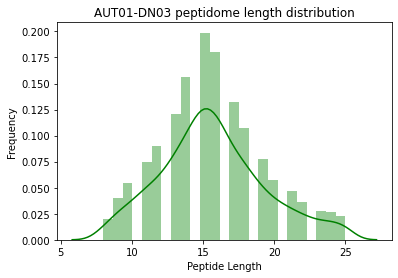

In [6]:
peptide_length: List[int] = exp.get_peptides_length()
# plot the length distribution
fig=plot_peptide_length_dist(peptide_length,{'color':'green'},
                             title='AUT01-DN03 peptidome length distribution') 

### The number of peptides per protein 

In [8]:
num_per_protein: pd.DataFrame = exp.get_peptides_per_protein() 
# show the first 10 elements 
num_per_protein.head(10)

,Proteins,Number_of_Peptides
335,Q9Y6R7,115
15,P04114,93
608,P68871,56
104,P69905,41
438,P68032,37
181,P04406,37
396,P62736,37
220,P63267,31
731,P61769,31
75,P02751,30


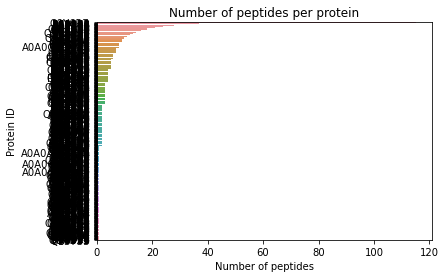

In [9]:
# we can visualize the number of peptides per protein 
fig=plot_num_peptides_per_parent(num_per_protein)      

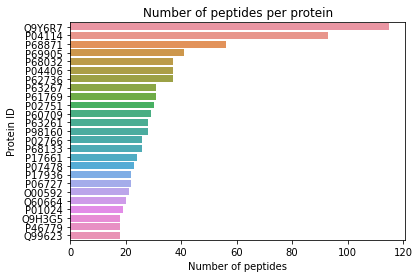

In [10]:
# we can also focus in the first-top 25 protein to get a clearer picture 
fig=plot_num_peptides_per_parent(num_per_protein,25)

### The gene expression of the parent proteins 

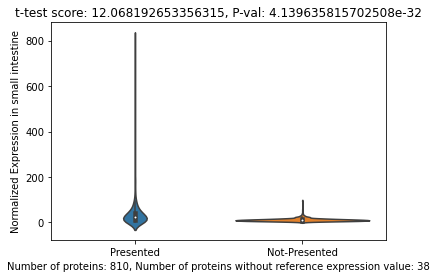

In [11]:
parent_protein_exp: pd.DataFrame = exp.get_expression_of_parent_proteins()
reference_gene_expression: pd.DataFrame = exp.get_experiment_reference_tissue_expression()
fig=plot_parent_protein_expression_in_tissue(parent_protein_exp,reference_gene_expression, 
                                             tissue_name=exp.get_tissue_name()) 

### Plot the correlation between the gene expression and number of peptides observed

The number of genes without a reference expression is: 38


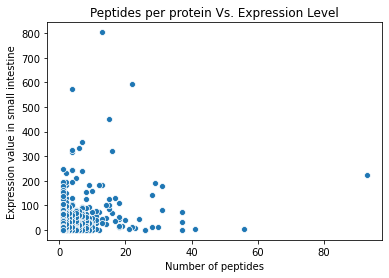

In [12]:
# get the number of peptides per parent protein 
num_peptides_parent: pd.DataFrame = exp.get_num_peptide_expression_table() 
# print the number of un-mapped genes 
print(f'The number of genes without a reference expression is: {num_peptides_parent.loc[num_peptides_parent.iloc[:,-1]==-1].shape[0]}')
# plot the gene expression vs. number of peptides 
fig=plot_gene_expression_vs_num_peptides(num_peptides_parent,tissue_name=exp.get_tissue_name())

### Get the location of the parent proteins

In [13]:
# get the source protein 
parent_protein_source_loc: pd.DataFrame = exp.get_main_sub_cellular_location_of_parent_proteins()
# show the head of the table  
print(parent_protein_source_loc.head(10))
print(parent_protein_source_loc.shape)

  Proteins                      Main_locations
0   O00757         Nucleoplasm;Plasma membrane
1   P13667               Endoplasmic reticulum
2   Q13310                             Cytosol
3   P60709                                 UNK
4   O00585                                 UNK
5   P12956                         Nucleoplasm
6   P11279                                 UNK
7   P01009                            Vesicles
8   Q8N5G0                 Cytosol;Nucleoplasm
9   Q6UXI9  Cell Junctions;Cytosol;Nucleoplasm
(810, 2)


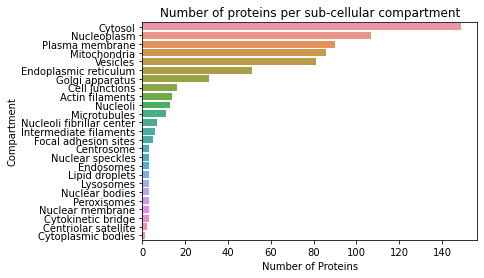

In [15]:
# get the number of proteind in each location 
protein_counts: pd.DataFrame = exp.get_number_of_proteins_per_compartment() 
# plot the number of proteins per-location
fig=plot_num_protein_per_location(protein_counts,drop_unknown=True) 

#### Get the GO of the parent proteins 

In [16]:
# get the source protein 
parent_protein_go_id: pd.DataFrame = exp.get_go_location_id_parent_proteins()
# show the head of the table  
print(parent_protein_go_id.head(10))

  Proteins                                           GO_Terms
0   O00757  Nucleoplasm (GO:0005654);Plasma membrane (GO:0...
1   P13667                 Endoplasmic reticulum (GO:0005783)
2   Q13310                               Cytosol (GO:0005829)
3   P60709                                                UNK
4   O00585                                                UNK
5   P12956                           Nucleoplasm (GO:0005654)
6   P11279                                                UNK
7   P01009                              Vesicles (GO:0043231)
8   Q8N5G0  Cytosol (GO:0005829);Nucleoli (GO:0005730);Nuc...
9   Q6UXI9  Cell Junctions (GO:0030054);Cytosol (GO:000582...


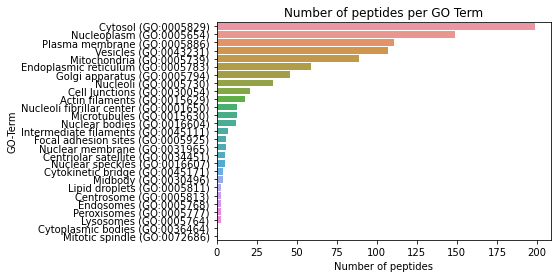

In [18]:
# get the number of proteind in each location 
protein_counts: pd.DataFrame = exp.get_number_of_proteins_per_go_term()
# plot the number of proteins per-location
fig=plot_num_peptide_per_go_term(protein_counts,drop_unknown=True) 

### plot the number of peptides per Location

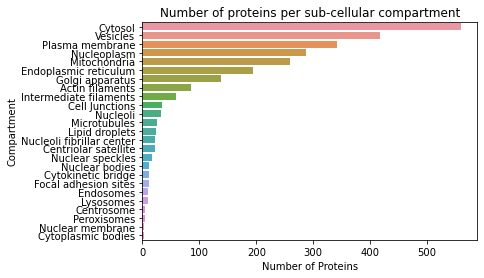

In [21]:
fig=plot_num_protein_per_location(exp.get_num_peptide_per_location(), drop_unknown=True)


### plot the number of peptides per GO-Term

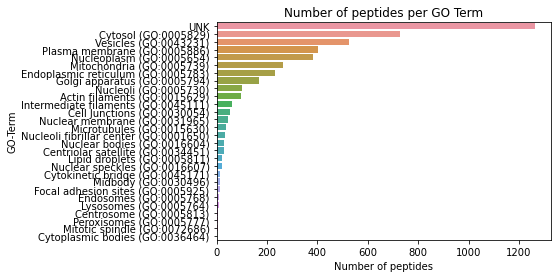

In [24]:
fig=plot_num_peptide_per_go_term(exp.get_num_peptide_per_go_term())

## Work with Peptide object

### Getting the unique, i.e. mono-parental, peptides in the database 

In [25]:
mono_parental_peptides: List[Peptide] = exp.get_mono_parent_peptides()
print(f'Number of mono-parental peptides: {len(mono_parental_peptides)}')
# print the sequnce of the first 10 peptides 
print('Top 10 peptides: ')
for idx in range(10):
    print('\t'+str(mono_parental_peptides[idx]))

Number of mono-parental peptides: 3167
Top 10 peptides: 
	EIVKEVSTYIKKIGYNPDT
	KPSERHVFIVDDFESF
	AKIIRHPKYNSRTLD
	IEGVDAEDGHGPGEQQ
	ITILGTVKPNANRIALD
	TADGIVSHLKKQAGPAS
	AYIPTNVISITD
	IALDDAKINFNEKLSQLQT
	TADGIVSHLKKQAGPASVP
	VVAVGAEYYLESLNKDKKHH


### Getting the peptides with its flanking region from every parent protein

In [29]:
flanking_region: List[str] = exp.get_flanked_peptides(flank_length=8)
# print the the first 10 sequences 
print(f'The total ')
for idx in range(10):
    print(flanking_region[idx])


The total 
PYSQKRYEEIVKEVSTYIKKIGYNPDTVAFVPISG
NELANIASKPSERHVFIVDDFESFEKIEDNLI
GNEQFINAAKIIRHPKYNSRTLDNDILLIKL
FLSSLTETIEGVDAEDGHGPGEQQKRKIVLDP
GGVVPRMLITILGTVKPNANRIALDFQRGNDVA
AGAYDGPRTADGIVSHLKKQAGPASVPLRTEEE
ETQAGDVSAYIPTNVISITDGQIFLETE
RITENDIQIALDDAKINFNEKLSQLQTYMIQFDQY
AGAYDGPRTADGIVSHLKKQAGPASVPLRTEEEFK
FKWGFAAFVVAVGAEYYLESLNKDKKHH


## Writing the generated sequences to a FASTA file 


In [30]:
write_auto_named_peptide_to_fasta(flanking_region, 'Tutorial2_flanked_regions.fasta')

### Analyzing the C-terminal sequences 

In [32]:
c_terminal_sequence: List[str] = exp.get_c_terminal_flanked_seqs(8)
# drop shorther seq -> peptide at the end of the protein. 
c_terminal_sequence = [elem for elem in c_terminal_sequence if len(elem) == 8]
# print the top 10 sequence
for idx in range(10):
    print(c_terminal_sequence[idx])

VAFVPISG
EKIEDNLI
NDILLIKL
KRKIVLDP
FQRGNDVA
VPLRTEEE
GQIFLETE
YMIQFDQY
LRTEEEFK
AQLIWSRA


In [ ]:
n_terminal_sequence: List[str] = exp.get_n_terminal_flanked_seqs(8)
# drop shorther seq -> peptide at the end of the protein. 
n_terminal_sequence = [elem for elem in n_terminal_sequence if len(elem) == 8]
# print the top 10 sequence
for idx in range(10):
    print(n_terminal_sequence[idx])

### Get The Mapped Protein 

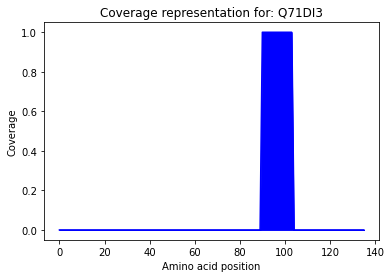

In [7]:
mapped_proteins: Dict[str,np.ndarray] = exp.get_mapped_proteins()
# sample a random protein from the keys 
sample_protein: str = random.choice(list(mapped_proteins.keys())) 
# plot the random protein 
fig=plot_protein_coverage(mapped_proteins[sample_protein],prot_name=sample_protein,col='blue') 

### Combining the number of peptides per-protein & coverage 

### Get Number of peptides per protein 

In [8]:
num_ppp : pd.DataFrame = exp.get_peptides_per_protein()  

### plot randomly selected three proteins

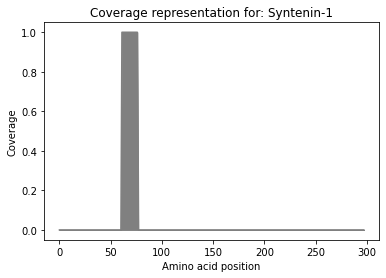

In [9]:
fig=plot_protein_coverage(mapped_proteins['O00560'],col='grey',prot_name='Syntenin-1') 

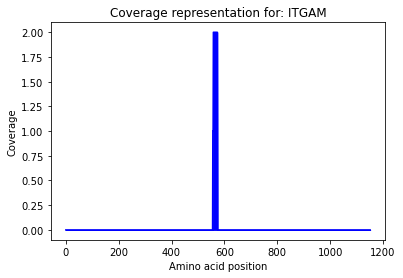

In [10]:
fig=plot_protein_coverage(mapped_proteins['P11215'],col='blue',prot_name='ITGAM') 

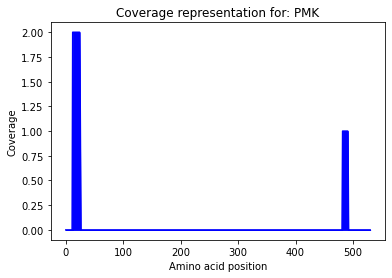

In [11]:
fig=plot_protein_coverage(mapped_proteins['P14618'],col='blue',prot_name='PMK') 

Here we are going to focus our analysis on the top Four proteins with most number of eluted peptides

## 3D structure analysis 

### Analyzing O00560 protein 

In [13]:
# get its Protein DataBank ID
protein_id: pd.DataFrame = map_from_uniprot_pdb(uniprots=['O00560'])
print(protein_id)
path_to_file=download_pdb_entry(protein_id.PDB.tolist()[0]) # download and view the first match 
imposed_coverage_on_3D_structure(path2mmCIF=path_to_file, mapped_protein=mapped_proteins['O00560'],
                                low='grey',high='red')

   Uniprot-ID   PDB
0      O00560  1N99
1      O00560  1NTE
2      O00560  1OBX
3      O00560  1OBY
4      O00560  1OBZ
5      O00560  1R6J
6      O00560  1V1T
7      O00560  1W9E
8      O00560  1W9O
9      O00560  1W9Q
10     O00560  1YBO
11     O00560  4Z33


NGLWidget(background='black')

### Analyzing P11215 protein 

In [14]:
protein_id: pd.DataFrame = map_from_uniprot_pdb(uniprots=['P11215'])
path_to_file=download_pdb_entry(protein_id.PDB.tolist()[1]) # download and view the first match 
#print(mapped_proteins['P14618'])
imposed_coverage_on_3D_structure(path2mmCIF=path_to_file, mapped_protein=mapped_proteins['P11215'],
                                low='grey',high='red')

NGLWidget(background='black')

### Analyzing P14618

In [15]:
protein_id: pd.DataFrame = map_from_uniprot_pdb(uniprots=['P14618'])
path_to_file=download_pdb_entry(protein_id.PDB.tolist()[1]) # download and view the first match 
#print(mapped_proteins['P14618'])
imposed_coverage_on_3D_structure(path2mmCIF=path_to_file, mapped_protein=mapped_proteins['P14618'],
                                low='grey',high='red')

NGLWidget(background='black')